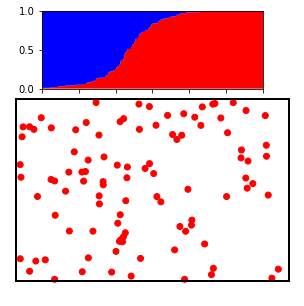

In [5]:
"""
Animation simulation a contagion of an ifectious disease, 
adapted by Roberto Cahuantzi based on the code:

Elastic collisions with Gravity
author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
"""
import numpy as np
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation
import matplotlib as mpl

class ParticleBox:
    """Orbits class
    
    init_state is an [N x 4] array, where N is the number of particles:
       [[x1, y1, vx1, vy1],
        [x2, y2, vx2, vy2],
        ...               ]

    bounds is the size of the box: [xmin, xmax, ymin, ymax]
    """
    def __init__(self,
                 init_state = [[1, 0, 0, -1],
                               [-0.5, 0.5, 0.5, 0.5],
                               [-0.5, -0.5, -0.5, 0.5]],
                 sick = [0, 1, 1],
                 bounds = [-3, 3, -2, 2],
                 size = 0.04,
                 M = 0.05,
                 G = 9.8):
        self.init_state = np.asarray(init_state, dtype=float)
        self.M = M * np.ones(self.init_state.shape[0])
        self.size = size
        self.state = self.init_state.copy()
        self.time_elapsed = 0
        self.bounds = bounds
        self.G = G
        self.sick = sick

    def step(self, dt):
        """step once by dt seconds"""
        self.time_elapsed += dt
        
        # update positions
        self.state[:, :2] += dt * self.state[:, 2:]

        # find pairs of particles undergoing a collision
        D = squareform(pdist(self.state[:, :2]))
        ind1, ind2 = np.where(D < 4 * self.size)
        unique = (ind1 < ind2)
        ind1 = ind1[unique]
        ind2 = ind2[unique]

        # update velocities of colliding pairs
        for i1, i2 in zip(ind1, ind2):
            # mass
            m1 = self.M[i1]
            m2 = self.M[i2]

            # location vector
            r1 = self.state[i1, :2]
            r2 = self.state[i2, :2]

            # velocity vector
            v1 = self.state[i1, 2:]
            v2 = self.state[i2, 2:]

            # relative location & velocity vectors
            r_rel = r1 - r2
            v_rel = v1 - v2

            # momentum vector of the center of mass
            v_cm = (m1 * v1 + m2 * v2) / (m1 + m2)

            # collisions of spheres reflect v_rel over r_rel
            rr_rel = np.dot(r_rel, r_rel)
            vr_rel = np.dot(v_rel, r_rel)
            v_rel = 2 * r_rel * vr_rel / rr_rel - v_rel

            # assign new velocities
            self.state[i1, 2:] = v_cm + v_rel * m2 / (m1 + m2)
            self.state[i2, 2:] = v_cm - v_rel * m1 / (m1 + m2)
            
            # define new condition
            s1 = self.sick[i1]
            s2 = self.sick[i2]
            
            if s1 == 1 or s2 == 1:
                self.sick[i1] = self.sick[i2] = 1

        # check for crossing boundary
        crossed_x1 = (self.state[:, 0] < self.bounds[0] + self.size)
        crossed_x2 = (self.state[:, 0] > self.bounds[1] - self.size)
        crossed_y1 = (self.state[:, 1] < self.bounds[2] + self.size)
        crossed_y2 = (self.state[:, 1] > self.bounds[3] - self.size)

        self.state[crossed_x1, 0] = self.bounds[0] + self.size
        self.state[crossed_x2, 0] = self.bounds[1] - self.size

        self.state[crossed_y1, 1] = self.bounds[2] + self.size
        self.state[crossed_y2, 1] = self.bounds[3] - self.size

        self.state[crossed_x1 | crossed_x2, 2] *= -1
        self.state[crossed_y1 | crossed_y2, 3] *= -1


#------------------------------------------------------------
# set up initial state
N = 100
frames = 600
np.random.seed(0)
cmap = mpl.cm.get_cmap('bwr')
init_state = -0.5 + np.random.random((N, 4))
init_state[:, 0] *= 5.9
init_state[:, 1] *= 3.9
init_state[:, 2:] *= 1.5
# sick_state = np.random.randint(0, 2, N)
sick_state = np.zeros(N)
sick_state[np.random.randint(0, 50, 1)] = 1
frame = np.arange(0, frames)
share_sick = np.zeros(frames)
share_sick[0] = sum(sick_state) / N
# bottom = np.zeros(frames)

box = ParticleBox(init_state, size=0.03, sick=sick_state)
dt = 1. / 30 # 30fps


#------------------------------------------------------------
# set up figure and animation
fig = plt.figure()
grid = plt.GridSpec(4, 4, hspace=-0.1, wspace=-0.1)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(grid[1:, :], aspect='equal', autoscale_on=False,
                     xlim=(-3.2, 3.2), ylim=(-2.4, 2.4))
ax_pdf = fig.add_subplot(grid[0, 1:3], xticklabels=[], 
                         xlim=(0, frames), ylim = (0, 1))

ax.set_axis_off()

# particles holds the locations of the particles
particles = ax.scatter(init_state[:, 0], init_state[:, 1], 
                       c = sick_state, cmap = cmap)
share = ax_pdf.fill_between(frame, share_sick, 
                            facecolor = cmap(1.0))

# rect is the box edge
rect = plt.Rectangle(box.bounds[::2],
                     box.bounds[1] - box.bounds[0],
                     box.bounds[3] - box.bounds[2],
                     ec='none', lw=2, fc='none')
ax.add_patch(rect)

# plt.tight_layout()

def init():
    """initialize animation"""
    global box, rect, pdf_ax
    particles.set_offsets(init_state[:, :2])
    particles.set_cmap(cmap)
    rect.set_edgecolor('none')
    share.get_paths()
    return particles, rect

def animate(i):
    """perform animation step"""
    global box, rect, dt, ax, fig, frame, share_sick, N, share
    box.step(dt)

    ms = int(fig.dpi * 2 * box.size * fig.get_figwidth()
             / np.diff(ax.get_xbound())[0])
    
    # update pieces of the animation
    rect.set_edgecolor('k')
    particles.set_offsets(box.state[:, :2])
    particles.set_array(box.sick[:])
    share_sick[i] = sum(box.sick[:]) / N
    ax_pdf.collections.clear()
    share = ax_pdf.fill_between(frame, share_sick, 
                                facecolor = cmap(1.0))
    ax_pdf.fill_between(frame, share_sick, np.ones_like(share_sick), 
                                facecolor = cmap(0.0))
    
    return particles, rect, share

ani = animation.FuncAnimation(fig, animate, frames=frames,
                              interval=10, blit=True, init_func=init)


# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
ani.save('Contagion.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()
